## Generation of additional diagrams from the manuscript

################################################################################################################

    "G-Protein Coupled Receptor-Ligand Dissociation Rates and Mechanisms from tauRAMD Simulations" 
     by Daria B. Kokh, Rebecca C. Wade
     submitte to JCTC , June 2021
     
     Figs. 3F,6F, and Fig.7
     
################################################################################################################

### Packages required:
    numpy ( 1.18.1)
    matplotlib (3.1.3)
    sklearn (0.22.1)
    scipy (1.4.1)
    pandas (1.0.2)
    seaborn (0.10.0)
    code is written on Python 3.x and tested on the version 3.7


### v 1.0
    02.06.2021
    Copyright (c) 2020
    Released under the EUPL Licence, v1.2 or any higher version
    
### Author: Daria Kokh
    Daria.Kokh@h-its.org or mcmsoft@h-its.org
    Heidelberg Institute of Theoretical Studies (HITS, www.h-its.org)
    Schloss-Wolfsbrunnenweg 35
    69118 Heidelberg, Germany

In [1]:
#from SetUp.trajectory_analysis import *
import warnings
warnings.filterwarnings("ignore")


%load_ext autoreload
%autoreload 2

In [2]:
import glob, os
import sys
import numpy as np

import pandas as pd
from pandas import ExcelFile 

from matplotlib import *
from matplotlib import cm
import matplotlib.ticker
from matplotlib import gridspec
import  pylab as plt
import seaborn as sns

from scipy import stats
from scipy.stats import norm

from sklearn import linear_model
from sklearn import preprocessing
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster import hierarchy as clust
from scipy.spatial.distance import pdist

import hashlib
from sklearn.datasets import make_blobs
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans
#from kmodes.kmodes import KModes


# 1. Plot relative Residence times (using pre-computed values)
    data generated by  tauRAMD.py script

>>>>>>>>>>>>>>>> [8.10810811e-01 9.67741935e+01 3.75000000e+03 2.17391304e+01]
-0.09108046934733259 1.98 0.18272183795469438 0.12821644636953589
1.9857595608853897 20.84 0.15040023110445433 0.11149987675947992
3.574031267727719 55.0 0.19629464514396822 0.1346985738974562
1.337242168318426 9.5 0.12646525656977248 0.09782335610368309
1.5628219249275708 times
2.0432042181922276 times
1.6360332659142913 times
1.2513818418718414 times
R2_12  0.9734515010338047 1.6233603127264828
-0.09108046934733259 0.68 0.21972505598650083 0.14521469258261147
1.9857595608853897 6.4 0.11157477505031843 0.08868968276136535
3.574031267727719 15.3 0.197919696551354 0.13545485529345513
1.337242168318426 3.6 0.05115252244738122 0.04575749056067513
1.924382102191097 times
1.9552969733340477 times
1.8448831025804993 times
1.8157139665526236 times
R2_14  0.9580648113060583 1.8850690361645668
2.976435872558675 times
4.22401273664167 times
3.0472024250781167 times
2.147200582581883 times
R2_16  0.8783518849586173 [1.

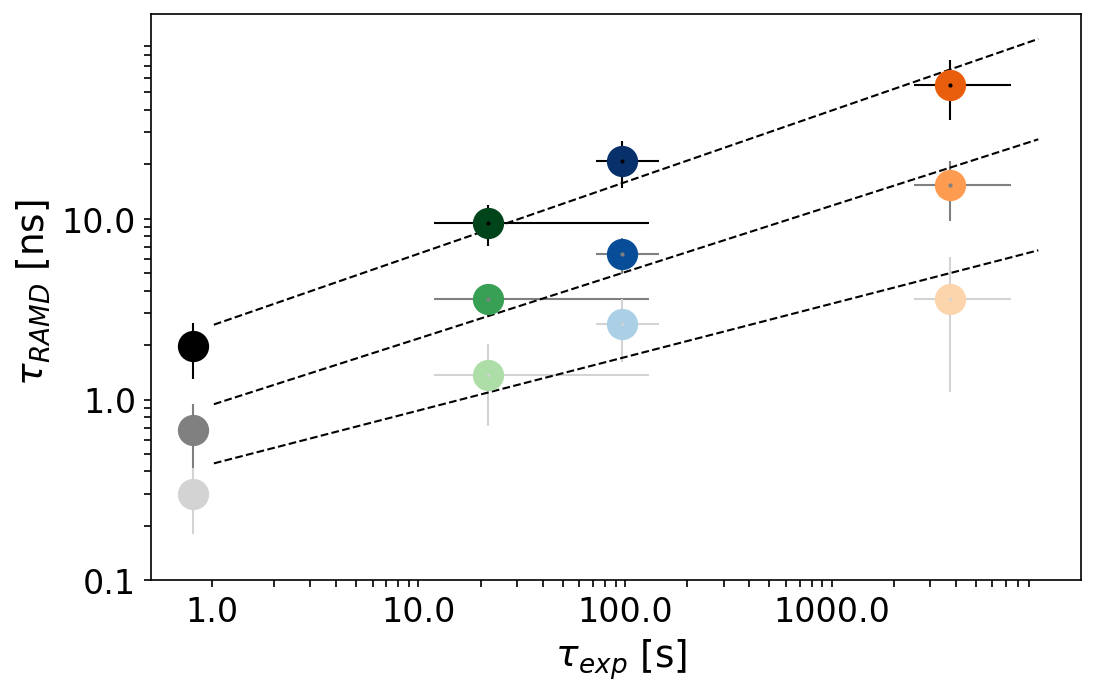

In [3]:
from sklearn.metrics import r2_score
def mue_pred(x_list,y_list,a,b):
    mu = 0
    for x,y in zip(x_list,y_list):
        d = np.abs((y-b)/a - x)
        mu += max(pow(10,x+d)/pow(10,x),pow(10,x-d)/pow(10,x))
        print(max(pow(10,x+d)/pow(10,x),pow(10,x-d)/pow(10,x)),"times")
    return(mu/np.shape(x_list)[0])
        
top = cm.get_cmap('Oranges_r', 10)
bottom = cm.get_cmap('Blues', 10)
pallet1 = np.vstack((top(np.linspace(0, 1, 10)), bottom(np.linspace(0, 1, 10))))
top = cm.get_cmap('Oranges_r', 10)
bottom = cm.get_cmap('Greens', 10)
pallet2 = np.vstack((top(np.linspace(0, 1, 10)), bottom(np.linspace(0, 1, 10))))

N = ["ACh-M2","IXO-M2","IXO & LY2119620- M2","β2AR - alprenolol"]

exp_orig = np.asarray( [74,0.62, 0.016, 2.76])/60.
exp_err_ori = np.asarray( [0.1, 0.21, 0.0079, 2.3])/60.
#exp_err_p =  np.log10(1/(exp_orig + exp_err_ori))-exp
#exp_err_m = exp-np.log10(1/(exp_orig - exp_err_ori))

#exp_err = 1/(exp_orig * np.log(10)) * exp_err
exp = np.log10(1/exp_orig)

exp_err_m =  1.0/(exp_orig + exp_err_ori)
exp_err_p = 1.0/(exp_orig - exp_err_ori)
exp_err_m =  exp-np.log10(exp_err_m)
exp_err_p = np.log10(exp_err_p)-exp
exp_err_p[np.isinf(exp_err_p)] = 0
print(">>>>>>>>>>>>>>>>",1/exp_orig)

tau16 = np.array([0.30, 2.6, 3.6, 1.37])
tau14 = np.array([0.68, 6.4, 15.3, 3.6])
tau12 = np.array([1.98, 20.84, 55,9.5])

tau16_sd = np.array([0.12, 0.98, 2.5, 0.66])
tau14_sd = np.array([0.27, 1.45, 5.6,0.4])
tau12_sd = np.array([0.68,6.1, 20, 2.4])
e = np.array([0.01,0.1,1,2,3,4])

fig, ax = plt.subplots(figsize = (8, 5),dpi=150)


data = []
data.append((np.array(tau12),np.array(tau12_sd),np.array(N)))
data_err_p = (np.log10(np.array(tau12)+np.array(tau12_sd)))- np.log10(np.array(tau12))
data_err_m =  np.log10(np.array(tau12)) -(np.log10(np.array(tau12)-np.array(tau12_sd)))

color=['k',pallet1[19],pallet1[3],pallet2[19]]

for i in range (0,len(exp)):
    if data[0][0][i] > 0:
        print(exp[i],data[0][0][i],data_err_m[i],data_err_p[i])
        plt.errorbar(x=exp[i], y=np.log10(np.array(tau12))[i], color=color[i],lw = 1,\
             marker = "o",ms=13,ls='none',label=N[i],mew=2)
plt.errorbar(x=exp, y=np.log10(np.array(tau12)),  yerr=[data_err_m,data_err_p], xerr=[exp_err_m,exp_err_p],lw = 1,marker = "o",ms=1,ls='none', c='k')

s = np.polyfit(exp[tau12> 0],np.log10(data[0][0][tau12> 0]),1)
r2 = r2_score(np.log10(data[0][0][tau12> 0]),s[0]*exp[tau12> 0]+s[1])        
print("R2_12 ",r2,mue_pred(exp,np.log10(data[0][0]),s[0],s[1]))
plt.plot(e, s[0]*e+s[1],lw=1,color='k',ls = '--')
#plt.legend(fontsize=12) 


data = []
data.append((np.array(tau14),np.array(tau14_sd),np.array(N)))
data_err_p = (np.log10(np.array(tau14)+np.array(tau14_sd)))- np.log10(np.array(tau14))
data_err_m =  np.log10(np.array(tau14)) -(np.log10(np.array(tau14)-np.array(tau14_sd)))

color=['gray',pallet1[18],pallet1[5],pallet2[16]]

for i in range (0,len(exp)):
    if data[0][0][i] > 0:
        print(exp[i],data[0][0][i],data_err_m[i],data_err_p[i])
        plt.errorbar(x=exp[i], y=np.log10(np.array(tau14))[i], color=color[i],lw = 1,\
             marker = "o",ms=13,ls='none',label=N[i],mew=2)
plt.errorbar(x=exp, y=np.log10(np.array(tau14)),  yerr=[data_err_m,data_err_p], xerr=[exp_err_m,exp_err_p],lw = 1,marker = "o",ms=1,ls='none', c='gray')

s = np.polyfit(exp[tau12> 0],np.log10(data[0][0][tau12> 0]),1)
r2 = r2_score(np.log10(data[0][0][tau12> 0]),s[0]*exp[tau12> 0]+s[1])        
print("R2_14 ",r2,mue_pred(exp,np.log10(data[0][0]),s[0],s[1]))
plt.plot(e, s[0]*e+s[1],lw=1,color='k',ls = '--')


data = []
data.append((np.array(tau16),np.array(tau16_sd),np.array(N)))
data_err_p = (np.log10(np.array(tau16)+np.array(tau16_sd)))- np.log10(np.array(tau16))
data_err_m =  np.log10(np.array(tau16)) -(np.log10(np.array(tau16)-np.array(tau16_sd)))

color=['lightgray',pallet1[13],pallet1[7],pallet2[13]]

for i in range (0,len(exp)):
    if data[0][0][i] > 0:
        plt.errorbar(x=exp[i], y=np.log10(data[0][0][i]),  color=color[i],lw = 1,\
             marker = "o",ms=13,ls='none',label=N[i],mew=2)
plt.errorbar(x=exp, y=np.log10(np.array(tau16)),  yerr=[data_err_m,data_err_p], xerr=[exp_err_m,exp_err_p],lw = 1,marker = "o",ms=0.5,ls='none', c='lightgray')

s = np.polyfit(exp[tau16> 0],np.log10(data[0][0][tau16> 0]),1)
r2 = r2_score(np.log10(data[0][0][tau16> 0]),s[0]*exp[tau16> 0]+s[1])        
print("R2_16 ",r2,np.corrcoef(exp[tau16> 0],np.log10(data[0][0][tau16> 0]))[0],mue_pred(exp,np.log10(data[0][0]),s[0],s[1]))
plt.plot(e, s[0]*e+s[1],lw=1,color='k',ls = '--')

y_tick_lable = []
y_tick_pos = []
for k in range(0,3):
    for ii,i in enumerate(range(pow(10,k),pow(10,k+1),pow(10,k))):            
        if(ii == 0): y_tick_lable.append(str(i/10.))
        else: y_tick_lable.append("")
        y_tick_pos.append(np.log10(i/10.))
x_tick_lable = []
x_tick_pos = []
for k in range(0,4):
    for ii,i in enumerate(range(pow(10,k),pow(10,k+1),pow(10,k))):            
        if(ii == 0): x_tick_lable.append(str(i/1))
        else: x_tick_lable.append("")
        x_tick_pos.append(np.log10(i))

plt.ylabel(r' $\tau_{RAMD} $ [ns]',fontsize=18)
plt.xlabel(r' $\tau_{exp} $ [s]',fontsize=18)
#plt.xticks(range(1,len(N)+1), N,fontsize=14)
plt.yticks(y_tick_pos,y_tick_lable, fontsize=16)
plt.xticks(x_tick_pos,x_tick_lable, fontsize=16)
#for i,n in enumerate(N):
#    plt.text(exp[i]+0.05, np.log10(data[0][0])[i],n,fontsize=16)
    
s = np.polyfit(exp,np.log10(data[0][0]),1)

plt.show()



# 2. Population of Egress routs 
## 2.1  b2AR 

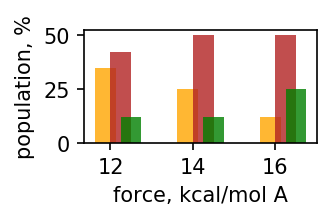

In [4]:
diff_pop=np.asarray([[35, 42,12],[25, 50,12],[12,50,25]])/100
fig = plt.figure(figsize = (2,1),facecolor='w',dpi=150)
width = 0.5
x = np.asarray([12,14,16])
rects1 = plt.bar(x - width/4,diff_pop.T[0], width, label='1',color = "orange", alpha=0.8)
rects2 = plt.bar(x + width/2,diff_pop.T[1], width, label='2',color = "firebrick", alpha=0.8)
rects2 = plt.bar(x + 2*width/2,diff_pop.T[2], width, label='3',color = "green", alpha=0.8)
#plt.legend()
plt.xlabel('force, kcal/mol A')
plt.ylabel('population, %')
plt.yticks(np.arange(0,0.6,0.25),np.arange(0,60,25),fontsize=10)
plt.show()

## 2.2   M2

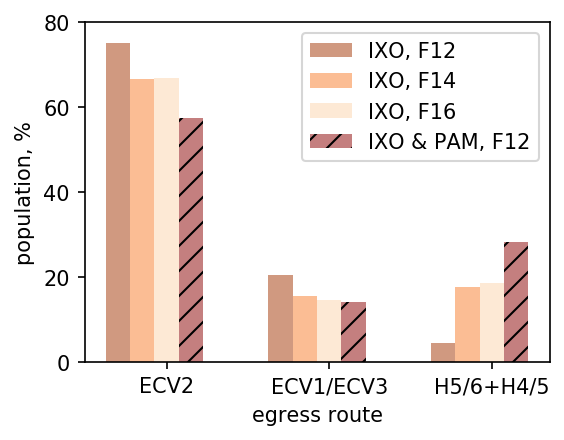

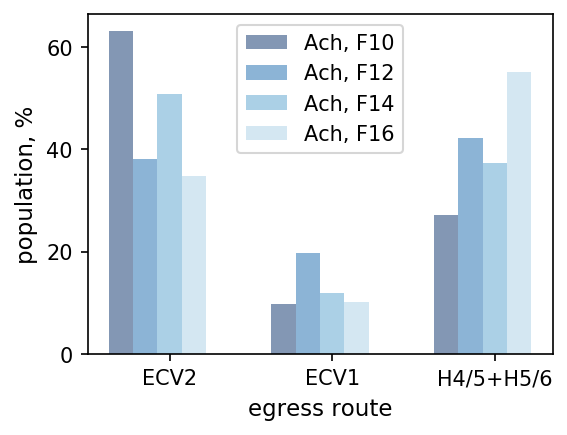

In [5]:
top = cm.get_cmap('Oranges_r', 10)
bottom = cm.get_cmap('Blues', 10)
color = np.vstack((top(np.linspace(0, 1, 10)), bottom(np.linspace(0, 1, 10))))
# IXO-F12, IXO-F14, IXO-F16, 
#IXO-PAM-F14, 
#ACh-F10,ACh-F12, ACh-F14,, ACh-F16
diff_pop=np.asarray([[103,28,0,7],[94,22,3,22],[101,22,6,22],[51,6,11,20],\
                     [91,14,37,2],[58,30,32,32],[102,24,35,40],[128,37,74,128]])  

diff_pop=np.asarray([[103,28,6],[94,22,25],[101,22,28], [81,20,40],\
                     [91,14,39],[58,30,64],[102,24,75],[128,37,202]])  
fig = plt.figure(figsize = (4,3),facecolor='w',dpi=150)
width = 0.6
x = np.asarray([1,2,3])
rects1 = plt.bar(x - width/2,diff_pop[0]/np.sum(diff_pop[0]), width/4, color = color[1], alpha=0.5, label="IXO, F12")
rects2 = plt.bar(x - width/4,diff_pop[1]/np.sum(diff_pop[1]), width/4, color = color[4], alpha=0.5, label="IXO, F14")
rects3 = plt.bar(x ,diff_pop[2]/np.sum(diff_pop[2]), width/4, color = color[7], alpha=0.5, label="IXO, F16")
rects4 = plt.bar(x + width/4,diff_pop[3]/np.sum(diff_pop[3]), width/4, color ="darkred", alpha=0.5, label="IXO & PAM, F12",hatch="//")
plt.yticks(np.arange(0,0.9,0.2),np.arange(0,90,20),fontsize=10)
plt.xticks(x,["ECV2","ECV1/ECV3","H5/6+H4/5"],fontsize=10)
plt.legend(fontsize=10,edgecolor=None,bbox_to_anchor=(1., 1.))
plt.xlabel('egress route',fontsize=10)
plt.ylabel('population, %',fontsize=10)

plt.show()
fig = plt.figure(figsize = (4,3),facecolor='w',dpi=150)
width = 0.6
rects5 = plt.bar(x - width/2,diff_pop[4]/np.sum(diff_pop[4]), width/4, color = color[19], alpha=0.5, label="Ach, F10")
rects6 = plt.bar(x - width/4,diff_pop[5]/np.sum(diff_pop[5]), width/4, color = color[17], alpha=0.5, label="Ach, F12")
rects7 = plt.bar(x ,diff_pop[6]/np.sum(diff_pop[6]), width/4, color = color[15], alpha=0.5, label="Ach, F14")
rects8 = plt.bar(x + width/4,diff_pop[7]/np.sum(diff_pop[7]), width/4, color = color[13], alpha=0.5, label="Ach, F16")
plt.xticks(x,["ECV2","ECV1","H4/5+H5/6"],fontsize=10)
plt.yticks(np.arange(0,0.8,0.2),np.arange(0,80,20),fontsize=10)
plt.legend(fontsize=10,edgecolor=None)
plt.xlabel('egress route',fontsize=11)
plt.ylabel('population, %',fontsize=11)

plt.show()